# Requirements + setup

In [ ]:
# ! pip install sqlalchemy

In [ ]:
import pandas as pd
import geopandas as gpd
import numpy as np
from shapely.ops import unary_union
import folium
from shapely.geometry import mapping
import json
from pyspark.sql import SparkSession
import unidecode

from matplotlib import pyplot as plt 
import seaborn as sns
from addressing.utils import libpostal
from fuzzywuzzy import fuzz
import nltk
from nltk.corpus import stopwords
from addressing.automatic_matching import automatic_matching
from addressing.automatic_matching.rooftop.rooftop import haversine_distance
import re
import sys, os
import sqlalchemy
from datetime import date


data_path = "/mnt/c/Users/tandon/OneDrive - TomTom/Desktop/tomtom/Workspace/01_Rooftop_accuracy/BFP_Analysis_USA/data/data"
state = "CT"
county = 'hartford'
delta = True

print("Delta :",delta)

Updated_geometries_pickle = os.path.join(data_path,state,county,"Apt_realignment_Build_former/FinalUpdated_APT_CT_hartford.pkl")
if os.path.isfile(Updated_geometries_pickle):
    print(Updated_geometries_pickle) 

In [ ]:
nltk.download('stopwords')

In [ ]:
DB = {
'host' : "10.137.173.84",
'port' : '5432',
'database' :  "STAN",
'user' : "strategicadmin",
'password' :  "TBmG4Yj3DdwOI+Aq"
}

class ReadAndWrite2PostgresDB:

    def __init__(self, engine):
        self.engine = engine

    def read_from_db(self, query, retry_num=3):

        for _ in range(retry_num):
            df = None
            try:
                df = pd.read_sql(query, self.engine)
                return df

            except Exception as e:
                print(e)

        return df

    def write_to_db(self, df, schema, table_name, retry_num=3):

        for _ in range(retry_num):
            try:
                
                df.to_sql(
                    table_name,
                    con=self.engine,
                    if_exists='append',
                    schema=schema,
                    index = False)
                print("Table stored!")
                return 1

            except Exception as e:
                print(e)

        return 0

In [ ]:
engine = sqlalchemy.create_engine(f'postgresql+psycopg2://{DB["user"]}:{DB["password"]}@{DB["host"]}:{DB["port"]}/{DB["database"]}',
                                        echo = False)

In [ ]:
raw2p = ReadAndWrite2PostgresDB(engine)

counties = 'cook', 'bexar', 'dallas', 'orange', 'maricopa', 'marion', 'tarrant', 'clark'

In [ ]:
date = date.today()
print(date)
print(county)

Stopwords

In [ ]:
countries_stopwords = {
  'br': stopwords.words('portuguese') + ['rua', 'avenida'], 
  'ca': stopwords.words('french') + stopwords.words('english') +  ['road', 'street', 'st.', 'st', 'rue', 'chemin', 'avenue'],
  'es': stopwords.words('spanish') + ['calle', 'avenida', 'callejón', 'paseo'],
  'fr': stopwords.words('french') + ['rue', 'chemin', 'avenue'],
  'gb': stopwords.words('english') + ['street', 'road', 'avenue', 'st.', 'st', 'drive'],
  'it': stopwords.words('italian') + ['via', 'viale', 'strada'],
  'mx': stopwords.words('spanish') + ['calle', 'avenida', 'callejón', 'paseo'],
  'us': stopwords.words('english') + ['street', 'road', 'avenue', 'st.', 'st', 'drive'],
  'be': stopwords.words('french') + ['rue', 'chemin', 'avenue'],
  'za': stopwords.words('english') + ['street', 'road', 'avenue', 'st.', 'st', 'drive']
}

countries_stopwords = {k:'|'.join(['\\b' + word + '\\b' for word in v]) for k, v in countries_stopwords.items()}

## Reading the data

### Sample addresses

In [8]:
sample_query = f"""SELECT * FROM "STAN_169".sample where county = '{county}'"""
sample_df = raw2p.read_from_db(query = sample_query)
sample_geom = gpd.GeoSeries.from_wkt(sample_df.geometry)
sample_gdf = gpd.GeoDataFrame(sample_df.drop('geometry', axis = 1),
                                geometry = sample_geom,
                                crs = 'EPSG:4326')

In [9]:
print(sample_gdf.shape)
sample_gdf.head()

(4379, 29)


,country,searched_query_unidecode_sample,libpostal_query,libpostal_response,libpostal_house,libpostal_category,libpostal_near,libpostal_house_number,libpostal_road,libpostal_unit,...,libpostal_state_district,libpostal_state,libpostal_country_region,libpostal_country,libpostal_world_region,lat_sample,lon_sample,county,sample_id,geometry
0,USA,"1781 Mountain Rd, West Suffield, CT 06093, USA","{""query"": ""1781 Mountain Rd, West Suffield, CT...","{'country': 'usa', 'city': 'west suffield', 'r...",,,,1781,mountain rd,,...,,ct,,usa,,41.992747,-72.714496,hartford,252ext3gghartford,"POLYGON ((-72.70551 41.99275, -72.70556 41.992..."
1,USA,"182 Alder Ln, Southington, CT 06489, USA","{""query"": ""182 Alder Ln, Southington, CT 06489...","{'country': 'usa', 'city': 'southington', 'roa...",,,,182,alder ln,,...,,ct,,usa,,41.600834,-72.909628,hartford,253ext3gghartford,"POLYGON ((-72.90064 41.60083, -72.90069 41.600..."
2,USA,"19 Hudson Ln, Windsor, CT 06095, USA","{""query"": ""19 Hudson Ln, Windsor, CT 06095, USA""}","{'country': 'usa', 'city': 'windsor', 'road': ...",,,,19,hudson ln,,...,,ct,,usa,,41.875854,-72.668264,hartford,254ext3gghartford,"POLYGON ((-72.65928 41.87585, -72.65932 41.875..."
3,USA,"198 Burlington Ave, Bristol, CT 06010, USA","{""query"": ""198 Burlington Ave, Bristol, CT 060...","{'country': 'usa', 'city': 'bristol', 'road': ...",,,,198,burlington ave,,...,,ct,,usa,,41.688072,-72.942319,hartford,255ext3gghartford,"POLYGON ((-72.93334 41.68807, -72.93338 41.687..."
4,USA,"198 Mohegan Dr, West Hartford, CT 06117, USA","{""query"": ""198 Mohegan Dr, West Hartford, CT 0...","{'country': 'usa', 'city': 'west hartford', 'r...",,,,198,mohegan dr,,...,,ct,,usa,,41.799604,-72.734977,hartford,256ext3gghartford,"POLYGON ((-72.72599 41.79960, -72.72604 41.798..."


### Source

In [10]:
source_query = f"""SELECT * FROM "STAN_169".source_v0 where county = '{county}'"""
source_df = raw2p.read_from_db(query = source_query)
source_geom = gpd.GeoSeries.from_wkt(source_df.geometry)
source_gdf = gpd.GeoDataFrame(source_df.drop('geometry', axis = 1),
                                geometry = source_geom,
                                crs = 'EPSG:4326')

In [11]:
source_gdf.head()

,feat_id,postal_code,hsn,state,city,street_name,country_code,prefix,suffix,pre_dir,post_dir,x,y,county,geometry
0,00005543-5400-2800-0000-00000003f390,06019,378,CT,Canton,E Hill Rd,USA,None,Rd,E,None,-72.894163,41.862555,hartford,POINT (-72.89416 41.86256)
1,00005543-5400-2800-0000-00000005670a,06042,28,CT,Manchester,Oliver Rd,USA,None,Rd,None,None,-72.536492,41.782295,hartford,POINT (-72.53649 41.78229)
2,00005543-5400-2800-0000-00000005ed6e,06062,4,CT,Plainville,Orchard Ln,USA,None,Ln,None,None,-72.884375,41.664746,hartford,POINT (-72.88438 41.66475)
3,8ec31e82-d77b-4c93-a65f-77ff60cfaedd,06019,25,CT,Canton,Highledge Rd,USA,None,Rd,None,None,-72.893784,41.832629,hartford,POINT (-72.89378 41.83263)
4,00005543-5400-2800-0000-000000071bd3,06096,126,CT,Windsor Locks,Center St,USA,None,St,None,None,-72.632924,41.936321,hartford,POINT (-72.63292 41.93632)


In [12]:
# gdf = gpd.GeoDataFrame(source_gdf[['feat_id','x','y','county','geometry']], crs="epsg:4326", geometry='geometry')
# gdf.to_crs("epsg:4326")
# gdf.to_file(os.path.join(data_path,state,county,'Apt_realignment_MSFT_OSM/source_df.shp'), driver='ESRI Shapefile')

In [13]:
# source_df = pd.read_pickle(f'wrang_source_v0_{county}.pickle')
# source_gdf = gpd.GeoDataFrame(source_df, geometry = 'geometry', crs='EPSG:4326')

### Ingesting Deltas

Here goes the table of new changes to make to coordinates:

In [14]:
print("DELTA for updating geometries is ",delta)
if delta:
    delta_table_read = pd.read_pickle(Updated_geometries_pickle)
    delta_table_read = delta_table_read[['feat_id', 'updated_geometries']]
    delta_table_read['datetime_version'] = pd.Timestamp.now(tz = 'utc')


DELTA for updating geometries is  True


In [15]:
if delta:
    delta_table_read.head()

In [16]:
if delta:
    delta_table_write = delta_table_read[['feat_id', 'updated_geometries', 'datetime_version']]
    delta_table_write['updated_geometries'] = delta_table_write['updated_geometries'].astype(str)

In [17]:
if delta:
    raw2p.write_to_db(df = delta_table_write, schema = 'STAN_169', table_name = 'delta_table')

Table stored!


### Reading Deltas

In [18]:
if delta:  
  delta_query = f"""
  SELECT * FROM "STAN_169".delta_table where county = '{county}'
  """
  delta_df = raw2p.read_from_db(query = delta_query)
  delta_geom = gpd.GeoSeries.from_wkt(delta_df.updated_geometries)
  delta_gdf = gpd.GeoDataFrame(delta_df.drop('updated_geometries', axis = 1),
                                  geometry = delta_geom,
                                  crs = 'EPSG:4326')

In [19]:
if delta:
  delta_gdf.head()

### Replacing Delta Changes

In [20]:
def replace_geometries(source_gdf, delta_gdf):
    '''
    Takes a 'source' geodataframe - copy of MNR database, a 'delta' geodataframe and replaces, for every APT (key: feat_id) in source dataframe, the 
    coordinates in the sorce with the coordinates in the new 

            Parameters:
                    source_gdf (gpd.GeoDataFrame): geodataframe containing MNR coordinates for every APT (feat_id)
                    delta_gdf (gpd.GeoDataFrame): geodataframe containing NEW coordinates for some APTs (feat_id)

            Returns:
                    source_gdf_new (gpd.GeoDataFrame): geodataframe containing MNR information for APT but with new coordinates
    '''
    # 
    delta_gdf_grouped = delta_gdf[delta_gdf.groupby('feat_id').datetime_version.transform('max') == delta_gdf.datetime_version]

    source_gdf_new = source_gdf.merge(delta_gdf_grouped[["feat_id", "geometry"]], on="feat_id", how="left")

    source_gdf_new.loc[~source_gdf_new.geometry_y.isna(), "geometry_x"] = source_gdf_new.loc[~source_gdf_new.geometry_y.isna(), "geometry_y"]

    source_gdf_new = source_gdf_new.drop(["geometry_y"], axis=1).rename({"geometry_x": "geometry"}, axis = 1)

    source_gdf_new = gpd.GeoDataFrame(source_gdf_new.drop('geometry', axis = 1), 
                                    geometry = source_gdf_new.geometry, crs = 'EPSG:4326')

    return source_gdf_new

In [21]:
if delta:
    source_delta = replace_geometries(source_gdf, delta_gdf)
    source_delta_gdf = gpd.GeoDataFrame(source_delta.drop('geometry', axis = 1), geometry = source_delta.geometry, crs = 'EPSG:4326')
    source_delta_gdf.x = source_delta_gdf.geometry.apply(lambda p: p.x)
    source_delta_gdf.y = source_delta_gdf.geometry.apply(lambda p: p.y)

### Joining Sample and Source - Spatial Join

In [22]:
if delta:
  joined_sample = source_delta_gdf.sjoin(sample_gdf, how='right', predicate='intersects')
else:
  joined_sample = source_gdf.sjoin(sample_gdf, how = 'right', predicate = 'intersects')

In [23]:
joined_sample.head()

,index_left,feat_id,postal_code,hsn,state,city,street_name,country_code,prefix,suffix,...,libpostal_state_district,libpostal_state,libpostal_country_region,libpostal_country,libpostal_world_region,lat_sample,lon_sample,county_right,sample_id,geometry
0,177.0,00005543-5400-2800-0000-0000000e9546,06093,90,CT,West Suffield,N Stone St,USA,None,St,...,,ct,,usa,,41.992747,-72.714496,hartford,252ext3gghartford,"POLYGON ((-72.70551 41.99275, -72.70556 41.992..."
0,12058.0,00005543-5400-2800-0000-0000000e9543,06093,148,CT,West Suffield,N Stone St,USA,None,St,...,,ct,,usa,,41.992747,-72.714496,hartford,252ext3gghartford,"POLYGON ((-72.70551 41.99275, -72.70556 41.992..."
0,12312.0,00005543-5400-2800-0000-0000000e9559,06093,233,CT,West Suffield,N Stone St,USA,None,St,...,,ct,,usa,,41.992747,-72.714496,hartford,252ext3gghartford,"POLYGON ((-72.70551 41.99275, -72.70556 41.992..."
0,14007.0,00005543-5400-2800-0000-0000000e953e,06093,1761,CT,West Suffield,Mountain Rd,USA,None,Rd,...,,ct,,usa,,41.992747,-72.714496,hartford,252ext3gghartford,"POLYGON ((-72.70551 41.99275, -72.70556 41.992..."
0,15913.0,00005543-5400-2800-0000-0000000e9552,06093,53,CT,West Suffield,N Stone St,USA,None,St,...,,ct,,usa,,41.992747,-72.714496,hartford,252ext3gghartford,"POLYGON ((-72.70551 41.99275, -72.70556 41.992..."


In [24]:
# if delta: 
#   del source_gdf
#   del delta_gdf
# else:
#   del source_delta_gdf

In [25]:
joined_sample.rename({
    'hsn': 'hsnum',
    'street_name': 'st_name',
    'postal_code': 'zip_code'
},
axis = 1, 
inplace = True)

# Parsing Joined Sample

In [26]:
def parse_joined_sample(spatial_joined_df: pd.DataFrame) -> pd.DataFrame:
    '''Function inversely parses the addresses to create a searched query format so that the addresses in the source 
    can be compared to the addresses in the sample.

    :param spatial_joined_df: DataFrame that contains the addresses from the source that are within the polygon of 
    the sample generated. It must contain the columns: ['hsn', 'unit_type', 'unit_num', 'pre_dir', 'prefix', 'suffix'
    'post_dir', 'city', 'state', 'zip_code']
    :type spatial_joined_df: pd.DataFrame
    :return: The same dataframe with a column that contains the full addresses inversely parsed.
    :rtype: pd.DataFrame
    '''

    df = spatial_joined_df.copy()

    dict_of_columns = {
        'hsnum': ' ', 'pre_dir': ' ', 'st_name': ' ', 'suffix': ', ', 'city': ' ', 'state': ' ', 'zip_code': ', ', 'country': ''
    }
    df['pre_dir'].fillna('', inplace=True)
    df['prefix'].fillna('', inplace=True)
    df['suffix'].fillna('', inplace=True)
    df['post_dir'].fillna('', inplace=True)

    for column in dict_of_columns.keys():

        df[column + '_modified'] = df[column].astype(str) + dict_of_columns[column]

    list_of_modified_columns = [col for col in df.columns if '_modified' in col]

    df['searched_query'] = df[list_of_modified_columns].sum(axis=1)

    df['street_name'] = df['pre_dir'] + ' ' + df['prefix'] + ' ' + df['st_name'] + ' ' + df['suffix'] + ' ' + df['post_dir']
    df['name'] = '' #df['state']

    df = df.rename(columns={'hsnum': 'hsn', 'searched_query': 'address', 'zip_code': 'postal_code', 'city': 'place_name', 'y': 'lat', 'x': 'lon'})
    return df

In [27]:
parsed_df = parse_joined_sample(joined_sample)
parsed_df.head()

,index_left,feat_id,postal_code,hsn,state,place_name,st_name,country_code,prefix,suffix,...,pre_dir_modified,st_name_modified,suffix_modified,city_modified,state_modified,zip_code_modified,country_modified,address,street_name,name
0,177.0,00005543-5400-2800-0000-0000000e9546,06093,90,CT,West Suffield,N Stone St,USA,,St,...,N,N Stone St,"St,",West Suffield,CT,"06093,",USA,"90 N N Stone St St, West Suffield CT 06093, USA",N N Stone St St,
0,12058.0,00005543-5400-2800-0000-0000000e9543,06093,148,CT,West Suffield,N Stone St,USA,,St,...,N,N Stone St,"St,",West Suffield,CT,"06093,",USA,"148 N N Stone St St, West Suffield CT 06093, USA",N N Stone St St,
0,12312.0,00005543-5400-2800-0000-0000000e9559,06093,233,CT,West Suffield,N Stone St,USA,,St,...,N,N Stone St,"St,",West Suffield,CT,"06093,",USA,"233 N N Stone St St, West Suffield CT 06093, USA",N N Stone St St,
0,14007.0,00005543-5400-2800-0000-0000000e953e,06093,1761,CT,West Suffield,Mountain Rd,USA,,Rd,...,,Mountain Rd,"Rd,",West Suffield,CT,"06093,",USA,"1761 Mountain Rd Rd, West Suffield CT 06093, USA",Mountain Rd Rd,
0,15913.0,00005543-5400-2800-0000-0000000e9552,06093,53,CT,West Suffield,N Stone St,USA,,St,...,N,N Stone St,"St,",West Suffield,CT,"06093,",USA,"53 N N Stone St St, West Suffield CT 06093, USA",N N Stone St St,


In [28]:
del joined_sample

# Matching Adresses

In [29]:
def apt_similarity_filter(
    #country:str,
    df:pd.DataFrame,
    sample_df:pd.DataFrame,
    stopwords_pattern: str = '') -> pd.DataFrame:
    """Performs matching after making call in a given radius

    :param country: country to call in MNR
    :type country: str
    :param df: DataFrame containing the sample addresses (must have coordinates)
    :type df: pd.DataFrame
    :param sample_df: DataFrame containing libpostal components for sample (df) addresses
    :type sample_df: pd.DataFrame
    :param radius: radius of the buffer
    :type radius: float
    :param inner_radius: radius in meters of a smaller buffer. When bigger than zero, we are essentially getting the point in a disk, defaults to 0
    :type inner_radius: int or float, optional
    :param stopwords_pattern: regex pattern to remove stopwords, if needed. Optional, defaults to None
    :type stopwords_pattern: str
    :return: DataFrame with the APTs that matched
    :rtype: pd.DataFrame
    """
    apts_df = df.copy()

    # Fill NAs
    apts_df[['address', 'street_name', 'hsn', 'postal_code',
                    'place_name', 'name']] = apts_df[['address', 'street_name', 'hsn',
                                                                            'postal_code', 'place_name', 'name']].fillna('')

    # Drop duplicates
    #apts_df = apts_df.drop_duplicates(['searched_query', 'address']).reset_index(drop=True)
    
    
    # Create extra columns for stopwords, optional unidecode 
    cols_stopwords = ['address', 'street_name', 'place_name']
    for col in cols_stopwords:
        col_create = col + '_no_stopwords'
        apts_df[col_create] =  apts_df[col].str.replace(stopwords_pattern, '', case=False, regex=True)
        
    for col in cols_stopwords:
        col_create = col + '_no_stopwords_unidecode'
        apts_df[col_create] =  apts_df[col+'_no_stopwords'].apply(lambda x: unidecode.unidecode(x))
        
    
    # Merge to APTs
    #apts_df = apts_df.merge(sample_df.drop(columns=['country', 'searched_query_unidecode_sample']),
    #                                      how='left', 
    #                                      on=['searched_query'])
    apts_df['libpostal_road_no_stopwords'] = apts_df.libpostal_road.str.replace(stopwords_pattern, '', case=False, regex=True)


    # House number similarity: filter obvious non matches
    apts_df['hsn_similarity'] = list(map(fuzz.token_set_ratio, apts_df.libpostal_house_number, apts_df.hsn))
    apts_df['re_pattern'] = '\\b' + apts_df.hsn.astype(str) + '\\b'
    #apts_df['hsn_in_query'] = apts_df.apply(lambda x: bool(re.search(x.re_pattern, x.searched_query_unidecode_sample)), axis=1)
    #apts_df['hsn_similarity'] = np.where((apts_df.hsn_in_query), 100, apts_df.hsn_similarity)

    dropped_df = apts_df.loc[apts_df.hsn_similarity <= 60].reset_index(drop=True)
    
    
    apts_df = apts_df.loc[apts_df.hsn_similarity > 60].reset_index(drop=True)

    # Postal code similarity
    apts_df['postcode_similarity'] = list(map(fuzz.WRatio, 
                                                     apts_df.libpostal_postcode, 
                                                     apts_df.postal_code.fillna('').astype(str)))
    apts_df['postcode_similarity'] = np.where(apts_df.libpostal_postcode=='', np.nan,
                                                     np.where(apts_df.postal_code=='', 50, apts_df.postcode_similarity))

    
    # Road similarity
    apts_df['road_similarity'] = list(map(fuzz.token_set_ratio, 
                                                 apts_df.libpostal_road_no_stopwords, 
                                                 apts_df.street_name_no_stopwords))
    apts_df['road_similarity_unidecode'] = list(map(fuzz.token_set_ratio, 
                                                           apts_df.libpostal_road_no_stopwords, 
                                                           apts_df.street_name_no_stopwords_unidecode)) 
    apts_df['road_similarity'] = apts_df[['road_similarity', 'road_similarity_unidecode']].max(axis=1)
    
    # Locality similarity
    apts_df['searched_query_tokens'] = (apts_df.libpostal_road.astype(str) + ' ' + 
                                               apts_df.libpostal_house_number.astype(str) + ' ' + 
                                               apts_df.libpostal_postcode.astype(str))
    
    apts_df['provider_tokens'] = (apts_df.street_name.astype(str) + ' ' + 
                                         apts_df.hsn.astype(str) + ' ' + apts_df.postal_code.astype(str))
    apts_df['aux_searched_query'] = apts_df.apply(lambda x: automatic_matching.replace_tokens(x.searched_query_unidecode_sample, x.searched_query_tokens), axis=1)
    apts_df['aux_provider_address'] = apts_df.apply(lambda x: automatic_matching.replace_tokens(x.address, x.provider_tokens), axis=1)
    apts_df['aux_provider_address'] = apts_df.aux_provider_address.fillna('').apply(lambda x: unidecode.unidecode(x))
    apts_df['locality_wratio'] = apts_df.apply(lambda x: fuzz.WRatio(str(x.aux_searched_query).lower(), str(x.aux_provider_address).lower()), axis=1)
    apts_df['locality_city_state_ratio'] = apts_df.apply(lambda x: fuzz.WRatio(str(x.libpostal_city) + ' ' + str(x.libpostal_state),
                                                                                            str(x.place_name) + ' ' + str(x.name)), axis=1)
    apts_df['locality_similarity'] = apts_df[['locality_wratio', 'locality_city_state_ratio']].mean(axis=1)

    apts_df['mnr_query_distance'] = apts_df.apply(lambda x: haversine_distance(x.lat, x.lon,
                                                                                               x.lat_sample, x.lon_sample)
                                                                  if not np.isnan(x.lat) else 1e7
                                                                  , axis=1)

    # Compute mean similarity
    apts_df['mean_similarity'] = (apts_df[['locality_similarity', 'hsn_similarity', 
                                                         'postcode_similarity', 'road_similarity']].mean(axis=1)
                                        * np.where(apts_df.hsn_similarity >= 70 , 1, 0)
                                        * np.where(apts_df.road_similarity >= 60 , 1, 0)  
                                        * np.where(apts_df.mnr_query_distance > 1000, 0, 1)
                                        )


    apts_df_matching = (
        apts_df.sort_values(by='mnr_query_distance')
        .loc[apts_df.groupby(['sample_id'])
        .mean_similarity.idxmax()]
        .reset_index(drop=True)
    )


    # Compute matching
    apts_df_matching['match'] = pd.NaT
    
    apts_df_matching['match'] = np.where(apts_df_matching.mean_similarity >= 70, 1, pd.NaT) #90 so far best

    #address_matches = apts_df_matching['searched_query_unidecode_sample']
    address_sample_ids = apts_df_matching['sample_id']
    
    #non_matches = dropped_df[~dropped_df['searched_query_unidecode_sample'].isin(address_matches)]
    non_matches_ids = dropped_df[~dropped_df['sample_id'].isin(address_sample_ids)]
    
    #addresses_to_add = non_matches['searched_query_unidecode_sample'].unique()
    addresses_to_add_ids = non_matches_ids['sample_id'].unique()
     
    addresses_id_df = pd.DataFrame(
        {'sample_id': addresses_to_add_ids, 'match': [pd.NaT] * len(addresses_to_add_ids)}
    )
    
    addresses_id_df = addresses_id_df.merge(sample_df[['sample_id', 'searched_query_unidecode_sample']], on = 'sample_id', how = 'left')
    
    cols_to_add = [col for col in apts_df_matching if col not in addresses_id_df.columns]
    
    addresses_id_df.loc[:, cols_to_add] = ''
    addresses_id_df_reordered = addresses_id_df[apts_df_matching.columns]
    
    apts_final = pd.concat([apts_df_matching, addresses_id_df_reordered])
    

    return apts_final

In [30]:
similarity_df = apt_similarity_filter(df = parsed_df, sample_df = sample_gdf, stopwords_pattern = countries_stopwords.get('us'))
del sample_gdf
del parsed_df

In [31]:
similarity_df['match'] = similarity_df['match'].fillna(0)

match_proportion = np.mean(similarity_df['match'])
clean_proportion = round(match_proportion * 100, 2)
print(f'The proportion of matches is: {clean_proportion}%')

The proportion of matches is: 90.93%


In [32]:
print(similarity_df.shape)
similarity_df.head()

(4379, 77)


,index_left,feat_id,postal_code,hsn,state,place_name,st_name,country_code,prefix,suffix,...,searched_query_tokens,provider_tokens,aux_searched_query,aux_provider_address,locality_wratio,locality_city_state_ratio,locality_similarity,mnr_query_distance,mean_similarity,match
0,228206.0,00005543-5400-2800-0000-00000004a413,06033,151,CT,Glastonbury,National Dr,USA,,Dr,...,national dr 151 06033,National Dr Dr 151 06033,glastonbury ct usa,glastonbury ct usa,100,84,92.0,6.0,98.0,1
1,211628.0,00005543-5400-2800-0000-00000006dde4,06109,225,CT,Wethersfield,Spring St,USA,,St,...,spring st 225 06109,Spring St St 225 06109,wethersfield ct usa,wethersfield ct usa,100,85,92.5,9.6,98.125,1
2,14202.0,00005543-5400-2800-0000-000000065a62,06074,240,CT,South Windsor,Ellington Rd,USA,,Rd,...,ellington rd 240 06074,Ellington Rd Rd 240 06074,south windsor ct usa,south windsor ct usa,100,86,93.0,123.0,98.25,1
3,39829.0,00005543-5400-2800-0000-00000003e8d0,06013,2,CT,Burlington,Angelas Way,USA,,Way,...,angelas way 25 06013,Angelas Way Way 2 06013,burlington ct usa,burlington ct usa,100,83,91.5,433.7,0.0,0
4,219387.0,00005543-5400-2800-0000-000000048e20,06073,266,CT,South Glastonbury,Foote Rd,USA,,Rd,...,foote rd 266 06073,Foote Rd Rd 266 06073,south glastonbury ct usa,south glastonbury ct usa,100,87,93.5,9.5,98.375,1


In [33]:
match_df = similarity_df[['feat_id', 'match', 'sample_id']]
match_df['county'] = county
match_df['datetime_run'] = pd.Timestamp.now(tz = 'utc')
match_df.rename({'match': 'asf'}, axis = 1, inplace = True)

/tmp/ipykernel_13867/2013992509.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  match_df['county'] = county
/tmp/ipykernel_13867/2013992509.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  match_df['datetime_run'] = pd.Timestamp.now(tz = 'utc')
/home/tandon/anaconda3/envs/pygeo/lib/python3.8/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/sta

In [34]:
print("shape of the data",match_df.shape)
match_df.head()

shape of the data (4379, 5)


,feat_id,asf,sample_id,county,datetime_run
0,00005543-5400-2800-0000-00000004a413,1,1000ext3gghartford,hartford,2022-12-13 08:27:17.499747+00:00
1,00005543-5400-2800-0000-00000006dde4,1,1001ext3gghartford,hartford,2022-12-13 08:27:17.499747+00:00
2,00005543-5400-2800-0000-000000065a62,1,1002ext3gghartford,hartford,2022-12-13 08:27:17.499747+00:00
3,00005543-5400-2800-0000-00000003e8d0,0,1003ext3gghartford,hartford,2022-12-13 08:27:17.499747+00:00
4,00005543-5400-2800-0000-000000048e20,1,1004ext3gghartford,hartford,2022-12-13 08:27:17.499747+00:00


#### Bootstrapping

In [35]:
import numpy as np
import statsmodels.api as sm
import pylab

def bootstrap_resample(df, agg_fun, times=1000, seed=0):
    reboot = []
    
    for t in range(times):
        df_boot = df.sample(frac = 1, replace=True, random_state = t+seed)
        reboot.append(agg_fun(df_boot))
    draw_qqplot(reboot)
    return reboot

def draw_qqplot(reboot):
    data = np.asarray(reboot)
    # sm.ProbPlot(data)
    sm.qqplot(data, line='45')
    pylab.show()


def percentile_bootstrap(df, agg_fun, conf=0.95, times=1000, seed=0):
    """Generic Percentile Bootstrap
    This function returns a percentile bootstrap confidence interval for a statistic.
    Args:
        df (pandas.DataFrame): DataFrame with the observed random vectors. Each row represents an observation an each column is a random variable.
        agg_fun (function): Aggregation function. This function should receive as input a pandas.DataFrame (resamples) and return a 
        number with the computed statistic.
        conf (float, optional): Confidence level of the returned interval. Defaults to 0.9.
        times (int, optional): Bootstrap resamples. Defaults to 1000.
        seed (int, optional): Random seed. Defaults to 0.
    Returns:
        numpy.array: Percentile Boostrap CI [lower, upper]
    """    
    reboot = bootstrap_resample(df, agg_fun, times, seed)
    return np.quantile(reboot, [(1-conf)/2, (1-conf)/2+conf])

##### Plot normalized Similarity data 

Text(0.5, 0.98, 'Data distribution')

<Figure size 720x504 with 0 Axes>

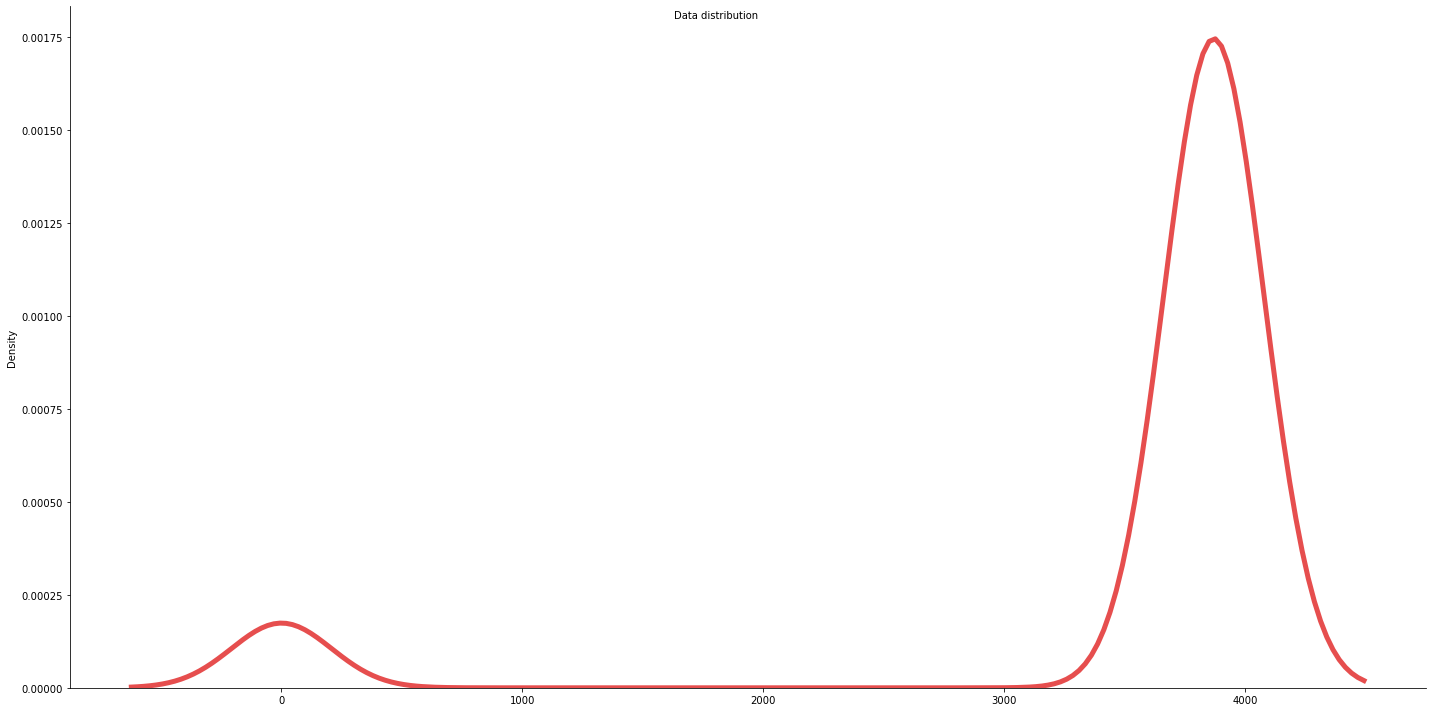

In [36]:
from scipy.stats import yeojohnson

norm_data,_ = yeojohnson(similarity_df['match'])

plt.figure(figsize=(10,7))
ax = sns.displot(norm_data, kind = "kde",color = "#e64e4e", height=10, aspect=2,
            linewidth = 5 )
ax.fig.suptitle('Data distribution', size = 10)

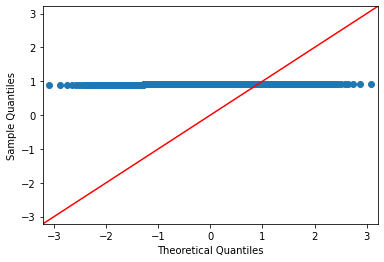

In [37]:
[lower_distance, upper_distance] = percentile_bootstrap(similarity_df['match'], np.mean)

# print(lower_distance,upper_distance)

In [38]:
if delta:
    version = date
else:
    version = 'New_benchmark'

results_sum = pd.DataFrame(
    data=[[lower_distance, match_proportion, upper_distance, '%', 'ASF', version, county]], 
    columns=['lower_bound', 'calculated_metric', 'upper_bound', 'units', 'metric', 'version', 'county'], index = None)
results_sum

,lower_bound,calculated_metric,upper_bound,units,metric,version,county
0,0.900891,0.90934,0.918018,%,ASF,2022-12-13,hartford


## Positional Accuracy

### 90th percentile

We consider the 90th percentile of the distance of matches as a metric for the Positional Accuracy. The distance we obtain below is be the distance for which 90% of the data is lower. The interesting thing about this metric is that it's expressed in terms of distance.

In [39]:
matches_df = similarity_df[similarity_df['match'] == 1]

matches_df['mnr_query_distance'] = matches_df['mnr_query_distance'].astype(float)

del similarity_df

/tmp/ipykernel_13867/1420054033.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matches_df['mnr_query_distance'] = matches_df['mnr_query_distance'].astype(float)


##### Plot normalized MNr Query Distance match Data 

Text(0.5, 0.98, 'Data distribution')

<Figure size 720x504 with 0 Axes>

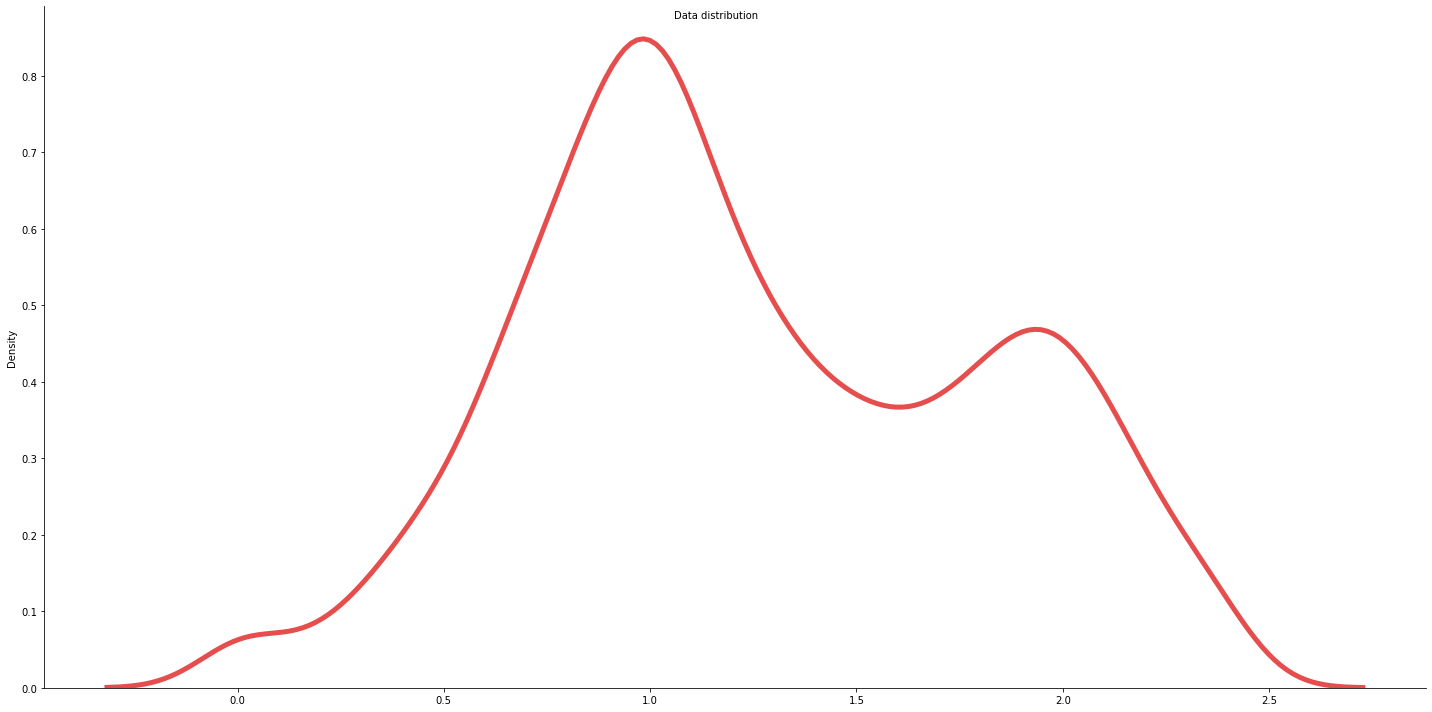

In [40]:
from scipy.stats import yeojohnson

norm_data,_ = yeojohnson(matches_df['mnr_query_distance'])

plt.figure(figsize=(10,7))
ax = sns.displot(norm_data, kind = "kde",color = "#e64e4e", height=10, aspect=2,
            linewidth = 5 )
ax.fig.suptitle('Data distribution', size = 10)

In [41]:
positional_accuracy_distance = round(np.quantile(matches_df['mnr_query_distance'], 0.9), 2)
print(f'Positional Accuracy (90th percentile distance) is: {positional_accuracy_distance}m')

Positional Accuracy (90th percentile distance) is: 51.7m


#### Bootstrapping

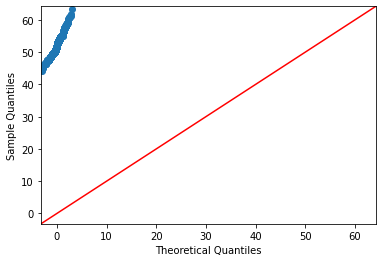

In [42]:
[lower_percentile90, upper_percentile90] = percentile_bootstrap(
    matches_df['mnr_query_distance'], lambda x: np.quantile(x, 0.9))

In [43]:
if delta:
    version = date
else:
    version = 'New_benchmark'

new_result = pd.DataFrame(
    data=[[lower_percentile90, positional_accuracy_distance, upper_percentile90, 'meters', '90p', version, county]], 
    columns=['lower_bound', 'calculated_metric', 'upper_bound', 'units', 'metric', 'version', 'county'], index = None)
results_sum = pd.concat([results_sum, new_result])
results_sum

,lower_bound,calculated_metric,upper_bound,units,metric,version,county
0,0.900891,0.90934,0.918018,%,ASF,2022-12-13,hartford
0,47.400000,51.70000,58.770250,meters,90p,2022-12-13,hartford


### % of matches below 50m

In [44]:
proportion_50m_matches = (matches_df['mnr_query_distance'] <= 50).mean()
nice_num_50m = round(proportion_50m_matches * 100, 1)
print(f'The calculated percentage of matches within 50 meters is {nice_num_50m}%')

The calculated percentage of matches within 50 meters is 89.8%


Text(0.5, 0.98, 'Data distribution')

<Figure size 720x504 with 0 Axes>

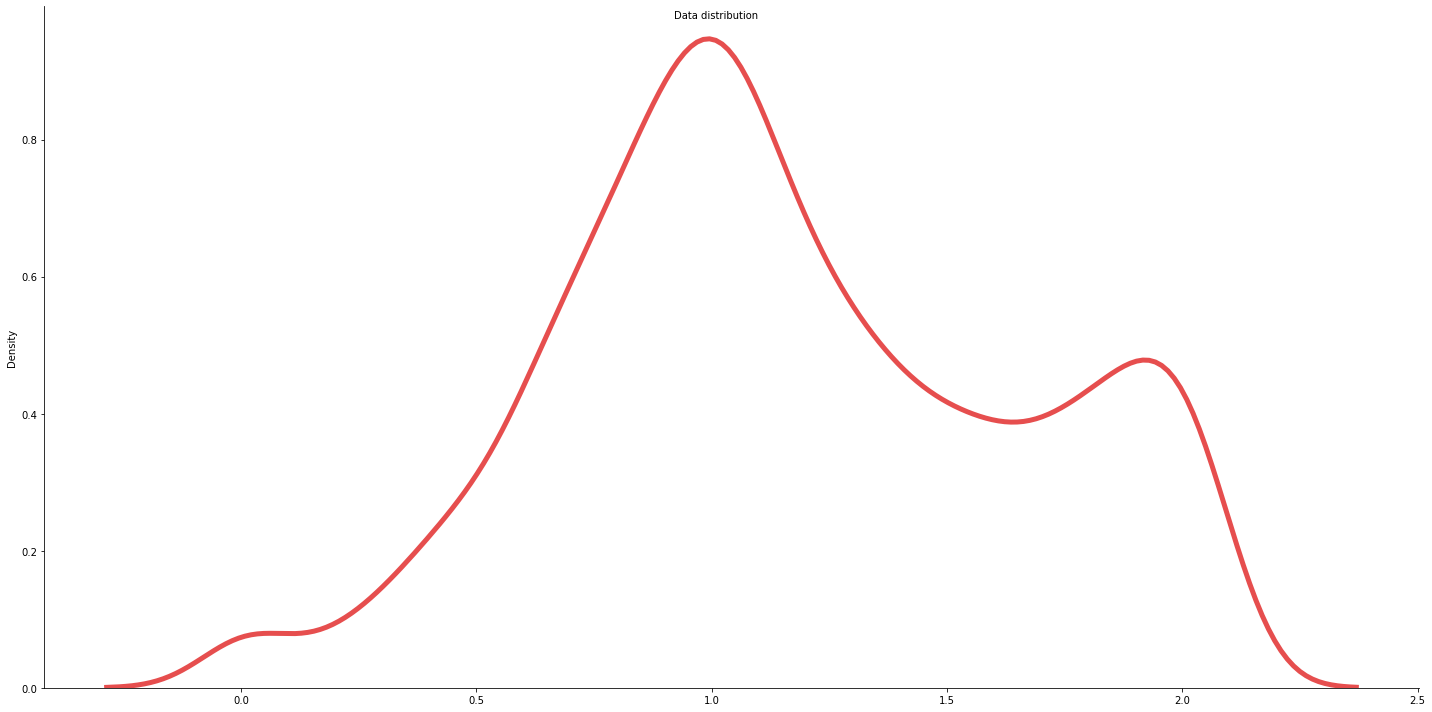

In [45]:

norm_data,_ = yeojohnson(matches_df['mnr_query_distance'].loc[matches_df['mnr_query_distance']<=50])

plt.figure(figsize=(10,7))
ax = sns.displot(norm_data, kind = "kde",color = "#e64e4e", height=10, aspect=2,
            linewidth = 5 )
ax.fig.suptitle('Data distribution', size = 10)

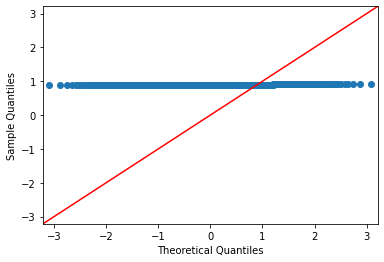

In [46]:
[lower_50m_pa, upper_50m_pa] = percentile_bootstrap(matches_df['mnr_query_distance'] <= 50, np.mean)

In [47]:
if delta:
    version = date
else:
    version = 'New_benchmark'

new_result = pd.DataFrame(
     data=[[lower_50m_pa, proportion_50m_matches, upper_50m_pa, '%', 'APA', version, county]], 
    columns=['lower_bound', 'calculated_metric', 'upper_bound', 'units', 'metric', 'version', 'county'])
results_sum = pd.concat([results_sum, new_result])
results_sum

,lower_bound,calculated_metric,upper_bound,units,metric,version,county
0,0.900891,0.90934,0.918018,%,ASF,2022-12-13,hartford
0,47.400000,51.70000,58.770250,meters,90p,2022-12-13,hartford
0,0.888498,0.89779,0.906837,%,APA,2022-12-13,hartford


In [48]:
# set(sample_gdf.sample_id) == set(similarity_df.sample_id)

# Join Matches Table

In [49]:
matches_df[['sample_id', 'mnr_query_distance']]

,sample_id,mnr_query_distance
0,1000ext3gghartford,6.0
1,1001ext3gghartford,9.6
2,1002ext3gghartford,123.0
4,1004ext3gghartford,9.5
5,1005ext3gghartford,24.5
...,...,...
4363,997ext3gghartford,21.2
4364,998ext3gghartford,184.6
4365,999ext3gghartford,1.4
4366,99ext3gghartford,3.1


In [50]:
match_df = match_df.merge(matches_df[['sample_id', 'mnr_query_distance']], on = ['sample_id'], how = 'left')
match_df['apa'] = match_df.mnr_query_distance.apply(lambda x: 1 if x < 52 else 0)
# match_df.drop('mnr_query_distance', axis = 1, inplace = True)
# raw2p.write_to_db(match_df, table_name = 'matches_table', schema = 'STAN_169')

In [51]:
if delta:
  match_df = match_df.merge(source_delta_gdf[['feat_id', 'geometry']], on = ['feat_id'], how = 'inner')
  del source_delta_gdf
else:
  match_df = match_df.merge(source_gdf[['feat_id', 'geometry']], on = ['feat_id'], how = 'inner')
  del source_gdf

In [52]:
match_df.geometry = match_df.geometry.astype(str)

# Store Results @ psql

### Storing Results

In [53]:
results_sum

,lower_bound,calculated_metric,upper_bound,units,metric,version,county
0,0.900891,0.90934,0.918018,%,ASF,2022-12-13,hartford
0,47.400000,51.70000,58.770250,meters,90p,2022-12-13,hartford
0,0.888498,0.89779,0.906837,%,APA,2022-12-13,hartford


In [54]:
# raw2p.write_to_db(results_sum, table_name = 'results', schema = 'STAN_169')

### Storing Matches

In [ ]:
match_df['version'] = date
match_df.head()

In [ ]:
from shapely import wkt 
# raw2p.write_to_db(match_df, table_name = 'matches_table', schema = 'STAN_169')
# match_df.to_csv(os.path.join(data_path,state,county,'Apt_realignment_MSFT/matching_df.csv'))
match_df['mnr_query_distance'] = match_df['mnr_query_distance'].apply(lambda x :float(x))
match_df['geometry'] = match_df['geometry'].apply(wkt.loads)

In [ ]:
gdf = gpd.GeoDataFrame(match_df[['feat_id','sample_id','apa','asf','geometry','mnr_query_distance']], crs="epsg:4326", geometry='geometry')
gdf.to_crs("epsg:4326")
gdf.to_file(os.path.join(data_path,state,county,'Apt_realignment_MSFT_OSM/matching_df.shp'), driver='ESRI Shapefile')

In [1]:
import pandas as pd 
path = "/mnt/c/Users/tandon/OneDrive - TomTom/Desktop/tomtom/Workspace/01_Rooftop_accuracy/APT-Realignment/data/Colorado/Apt_realignment_MSFT/updated_geometries_bfp-count_1_Parcels_08003/APT_realigned.pkl"


df = pd.read_pickle(path)
df.head()

,feat_id,iso_script,iso_lang_c,postal_cod,house_numb,state_prov,locality,street_nam,country_co,prefix,suffix,predir,postdir,sn_body,PRCLDMPID,updated_geometries,apt_bfp_dist
2,df726037-4406-4934-8ad7-e4f2ff7bfd17,Latn,ENG,81101-2545,297,CO,Alamosa,San Juan Ave,USA,None,Ave,None,None,San Juan,100660192_17725447,POINT (-105.86738 37.47284),4.9
2,00004358-3200-2800-0000-0000004019da,Latn,ENG,81101-2545,97,CO,Alamosa,San Juan Ave,USA,None,Ave,None,None,San Juan,100660192_17725447,POINT (-105.86738 37.47284),4.6
3,00004358-3200-2800-0000-0000004019db,Latn,ENG,81101-2504,711,CO,Alamosa,1st St,USA,None,St,None,None,1st,100660192_17725446,POINT (-105.86757 37.47282),1.2
4,00004358-3200-2800-0000-00000040f477,Latn,ENG,81101-2545,93,CO,Alamosa,San Juan Ave,USA,None,Ave,None,None,San Juan,100660192_17725445,POINT (-105.86737 37.47311),8.7
6,00004358-3200-2800-0000-0000004019de,Latn,ENG,81101-2545,75,CO,Alamosa,San Juan Ave,USA,None,Ave,None,None,San Juan,100660192_17725438,POINT (-105.86742 37.47368),3.4


In [2]:
df.to_csv('sample_updated_APT.csv')
